In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

tensor([[ 35.6071],
        [ 89.9486],
        [ 27.7702],
        [-45.4488]])

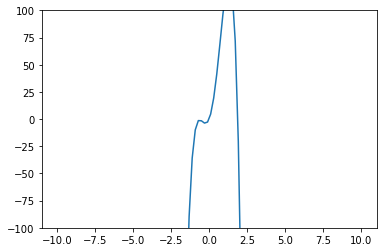

In [33]:
# No learning, just plotting a polynomial

parameter_scale = 100

x = torch.linspace(-10, 10, 100)

poly_order = 4
powers = torch.tensor([p + 1 for p in range(poly_order)])
x_poly = x.unsqueeze(-1).pow(powers)

coefficients = torch.randn(poly_order, 1) * parameter_scale

y = x_poly @ coefficients

plt.plot(x, y);
plt.ylim([-100, 100])

coefficients

In [39]:
num_epochs = 4
learning_rate = 0.1
batch_size = 128
weight_decay = 0.01
dropout_rate = 0.2

In [35]:
data_directory_path = '../data/'

mnist_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# Training data loader
train_dataset = torchvision.datasets.MNIST(
    root=data_directory_path, train=True, download=True, transform=mnist_transforms
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# Validation data loader
valid_dataset = torchvision.datasets.MNIST(
    root=data_directory_path, train=False, download=True, transform=mnist_transforms
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=len(valid_dataset), shuffle=True
)

In [36]:
nx = 28 * 28
ny = 10
shapes = (nx, 20, 20, 20, ny)

layers = [
    torch.nn.Sequential(torch.nn.Linear(n_in, n_out), torch.nn.ReLU())
    for n_in, n_out in zip(shapes, shapes[1:-1])
]

layers.append(torch.nn.Linear(shapes[-2], shapes[-1]))

model = torch.nn.Sequential(*layers)

loss = torch.nn.CrossEntropyLoss()

valid_costs = []
train_costs = []
accuracies = []

for epoch in range(num_epochs):

    # Set model to training mode
    model.train()

    # Update the model for each batch
    train_count = 0
    train_cost = 0
    for X, y in train_loader:

        # Compute model cost
        yhat = model(X.view(-1, nx))
        cost = loss(yhat, y)

        # Compute gradients
        model.zero_grad()
        cost.backward()

        # Update parameters
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

        train_count += X.shape[0]
        train_cost += cost.item()

    # Set model to evaluation mode
    model.eval()

    # Test model on validation data
    valid_count = 0
    valid_cost = 0
    valid_correct = 0
    with torch.no_grad():
        for X, y in valid_loader:

            # Compute model cost
            yhat = model(X.view(-1, nx))
            cost = loss(yhat, y)

            # Convert model output into discrete predictions
            predictions = yhat.argmax(dim=1, keepdim=True)

            # Compute number correct
            correct = predictions.eq(y.view_as(predictions)).double().sum().item()

            valid_count += X.shape[0]
            valid_cost += cost.item()
            valid_correct += correct

    train_cost /= train_count
    valid_cost /= valid_count
    valid_accuracy = valid_correct / valid_count

    ep_str = f"{epoch+1:>2}/{num_epochs}"
    tc_str = f"{train_cost:.2e}"
    vc_str = f"{valid_cost:.2e}"
    va_str = f"{valid_accuracy*100:.2f}"
    print(f"{ep_str}: TC={tc_str}, VC={vc_str}, Accuracy={va_str}%")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    accuracies.append(valid_accuracy)
    
    with torch.no_grad():
        for layer in model.parameters():
            print(layer.data.abs().mean())

print("Done.")

 1/4: TC=4.85e-03, VC=3.12e-05, Accuracy=90.61%
tensor(0.0264)
tensor(0.0231)
tensor(0.1579)
tensor(0.1367)
tensor(0.1572)
tensor(0.1163)
tensor(0.2076)
tensor(0.0770)
 2/4: TC=1.88e-03, VC=2.15e-05, Accuracy=93.58%
tensor(0.0294)
tensor(0.0253)
tensor(0.1714)
tensor(0.1390)
tensor(0.1666)
tensor(0.1163)
tensor(0.2268)
tensor(0.0835)
 3/4: TC=1.46e-03, VC=1.72e-05, Accuracy=94.70%
tensor(0.0318)
tensor(0.0268)
tensor(0.1814)
tensor(0.1414)
tensor(0.1735)
tensor(0.1161)
tensor(0.2386)
tensor(0.0875)
 4/4: TC=1.24e-03, VC=1.72e-05, Accuracy=94.87%
tensor(0.0338)
tensor(0.0276)
tensor(0.1888)
tensor(0.1436)
tensor(0.1776)
tensor(0.1153)
tensor(0.2454)
tensor(0.0924)
Done.


In [40]:
nx = 28 * 28
ny = 10
shapes = (nx, 20, 20, 20, ny)

layers = [
    torch.nn.Sequential(torch.nn.Linear(n_in, n_out), torch.nn.ReLU())
    for n_in, n_out in zip(shapes, shapes[1:-1])
]

layers.append(torch.nn.Linear(shapes[-2], shapes[-1]))

model = torch.nn.Sequential(*layers)

loss = torch.nn.CrossEntropyLoss()

valid_costs = []
train_costs = []
accuracies = []

for epoch in range(num_epochs):

    # Set model to training mode
    model.train()

    # Update the model for each batch
    train_count = 0
    train_cost = 0
    for X, y in train_loader:

        # Compute model cost
        yhat = model(X.view(-1, nx))
        cost = loss(yhat, y)

        # Compute gradients
        model.zero_grad()
        cost.backward()

        # Update parameters
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad + weight_decay * param

        train_count += X.shape[0]
        train_cost += cost.item()

    # Set model to evaluation mode
    model.eval()

    # Test model on validation data
    valid_count = 0
    valid_cost = 0
    valid_correct = 0
    with torch.no_grad():
        for X, y in valid_loader:

            # Compute model cost
            yhat = model(X.view(-1, nx))
            cost = loss(yhat, y)

            # Convert model output into discrete predictions
            predictions = yhat.argmax(dim=1, keepdim=True)

            # Compute number correct
            correct = predictions.eq(y.view_as(predictions)).double().sum().item()

            valid_count += X.shape[0]
            valid_cost += cost.item()
            valid_correct += correct

    train_cost /= train_count
    valid_cost /= valid_count
    valid_accuracy = valid_correct / valid_count

    ep_str = f"{epoch+1:>2}/{num_epochs}"
    tc_str = f"{train_cost:.2e}"
    vc_str = f"{valid_cost:.2e}"
    va_str = f"{valid_accuracy*100:.2f}"
    print(f"{ep_str}: TC={tc_str}, VC={vc_str}, Accuracy={va_str}%")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    accuracies.append(valid_accuracy)
    
    with torch.no_grad():
        for layer in model.parameters():
            print(layer.data.abs().mean())

print("Done.")

 1/4: TC=1.16e-02, VC=1.13e-04, Accuracy=60.65%
tensor(0.0089)
tensor(0.0080)
tensor(0.0478)
tensor(0.0127)
tensor(0.0436)
tensor(0.0135)
tensor(0.0867)
tensor(0.0638)
 2/4: TC=8.46e-03, VC=9.60e-05, Accuracy=66.95%
tensor(0.0091)
tensor(0.0087)
tensor(0.0495)
tensor(0.0143)
tensor(0.0449)
tensor(0.0158)
tensor(0.0903)
tensor(0.0593)
 3/4: TC=7.28e-03, VC=7.96e-05, Accuracy=76.72%
tensor(0.0096)
tensor(0.0101)
tensor(0.0505)
tensor(0.0123)
tensor(0.0415)
tensor(0.0119)
tensor(0.0931)
tensor(0.0421)
 4/4: TC=6.61e-03, VC=7.68e-05, Accuracy=79.69%
tensor(0.0097)
tensor(0.0094)
tensor(0.0505)
tensor(0.0110)
tensor(0.0413)
tensor(0.0122)
tensor(0.0953)
tensor(0.0382)
Done.


In [532]:
num_epochs = 20
batch_size = 1024
weight_decay = 0.001
dropout_rate = 0.2

nx = 28 * 28
ny = 10
shapes = (nx, 20, 20, 20, ny)


def create_layer(n_in, n_out):
    return torch.nn.Sequential(
        torch.nn.Linear(n_in, n_out),
        torch.nn.BatchNorm1d(n_out),
        torch.nn.Dropout(dropout_rate),
        torch.nn.ReLU(),
    )


layers = [create_layer(n_in, n_out) for n_in, n_out in zip(shapes, shapes[1:-1])]
layers.append(torch.nn.Linear(shapes[-2], shapes[-1]))

model = torch.nn.Sequential(*layers)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

valid_costs = []
train_costs = []
accuracies = []

for epoch in range(num_epochs):

    # Set model to training mode
    model.train()

    # Update the model for each batch
    train_count = 0
    train_cost = 0
    for X, y in train_loader:

        # Compute model cost
        yhat = model(X.view(-1, nx))
        cost = loss(yhat, y)

        # Compute gradients
        optimizer.zero_grad()
        cost.backward()

        # Update parameters
        optimizer.step()

        train_count += X.shape[0]
        train_cost += cost.item()

    # Set model to evaluation mode
    model.eval()

    # Test model on validation data
    valid_count = 0
    valid_cost = 0
    valid_correct = 0
    with torch.no_grad():
        for X, y in valid_loader:

            # Compute model cost
            yhat = model(X.view(-1, nx))
            cost = loss(yhat, y)

            # Convert model output into discrete predictions
            predictions = yhat.argmax(dim=1, keepdim=True)

            # Compute number correct
            correct = predictions.eq(y.view_as(predictions)).double().sum().item()

            valid_count += X.shape[0]
            valid_cost += cost.item()
            valid_correct += correct

    train_cost /= train_count
    valid_cost /= valid_count
    valid_accuracy = valid_correct / valid_count

    ep_str = f"{epoch+1:>2}/{num_epochs}"
    tc_str = f"{train_cost:.2e}"
    vc_str = f"{valid_cost:.2e}"
    va_str = f"{valid_accuracy*100:.2f}"
    print(f"{ep_str}: TC={tc_str}, VC={vc_str}, Accuracy={va_str}%")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    accuracies.append(valid_accuracy)

print("Done.")

 1/20: TC=8.65e-03, VC=3.54e-05, Accuracy=91.42%
 2/20: TC=4.84e-03, VC=2.68e-05, Accuracy=92.79%
 3/20: TC=4.24e-03, VC=2.37e-05, Accuracy=93.45%
 4/20: TC=3.94e-03, VC=2.25e-05, Accuracy=93.68%
 5/20: TC=3.76e-03, VC=2.11e-05, Accuracy=94.22%
 6/20: TC=3.62e-03, VC=2.00e-05, Accuracy=94.54%
 7/20: TC=3.50e-03, VC=1.99e-05, Accuracy=94.41%
 8/20: TC=3.45e-03, VC=1.97e-05, Accuracy=94.42%
 9/20: TC=3.35e-03, VC=1.92e-05, Accuracy=94.69%
10/20: TC=3.37e-03, VC=1.92e-05, Accuracy=94.61%
11/20: TC=3.29e-03, VC=1.86e-05, Accuracy=94.63%
12/20: TC=3.24e-03, VC=1.90e-05, Accuracy=94.77%
13/20: TC=3.22e-03, VC=1.92e-05, Accuracy=94.57%
14/20: TC=3.25e-03, VC=1.84e-05, Accuracy=94.81%
15/20: TC=3.18e-03, VC=1.79e-05, Accuracy=94.97%
16/20: TC=3.21e-03, VC=1.82e-05, Accuracy=94.82%
17/20: TC=3.17e-03, VC=1.90e-05, Accuracy=94.65%
18/20: TC=3.14e-03, VC=1.82e-05, Accuracy=94.74%
19/20: TC=3.14e-03, VC=1.81e-05, Accuracy=95.04%
20/20: TC=3.14e-03, VC=1.87e-05, Accuracy=94.69%
Done.


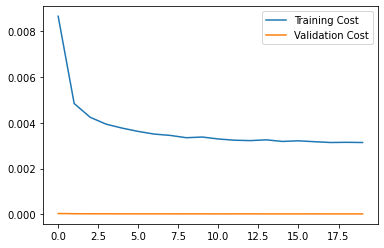

In [533]:
plt.plot(train_costs, label='Training Cost')
plt.plot(valid_costs, label='Validation Cost')
plt.legend();